# GLASSY MODULUS

In [12]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import layers
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [13]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\01-Glassy_Modulus.csv"
df = pd.read_csv(filePath)

In [14]:
#
smiles = df['SMILES']
smiles = [list(smile.strip('{} ').split(',')) for smile in smiles]

molar_ratio = df['Molar Ratio']
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(':')]
    m_r.append(ratio_list)

In [15]:
''''
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
'''
#function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, 128)
    return fp

#function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp

# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)

fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [multiply_fingerprint(fp, m_r_value) for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)]
    fingerprinted_polymer_data.append(multiplied_polymer)
    

#flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

#find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode = 'constant') for arr in flattened_arr]

new_array = np.stack(padded_arrays)

In [16]:
X = new_array
y = df['Glassy Modulus(GPa)'] #specify y

In [17]:
#Split data into training and testing sets
random_seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= random_seed)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

Epoch 1/1000
8/8 [==============================] - 2s 36ms/step - loss: 3.4960 - mape: 85.6538 - val_loss: 2.2439 - val_mape: 54.8581
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.4328 - mape: 61.2261 - val_loss: 2.4491 - val_mape: 94.4702
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.3604 - mape: 76.6047 - val_loss: 1.9727 - val_mape: 55.8802
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.1797 - mape: 51.1168 - val_loss: 1.8911 - val_mape: 50.9565
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.0382 - mape: 52.0395 - val_loss: 1.8468 - val_mape: 51.9126
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 1.9108 - mape: 47.1254 - val_loss: 1.7714 - val_mape: 49.4987
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 1.7788 - mape: 48.4867 - val_loss: 1.6965 - val_mape: 48.6274
Epoch 8/1000
8/8 [==============================] - 0s 8ms/st

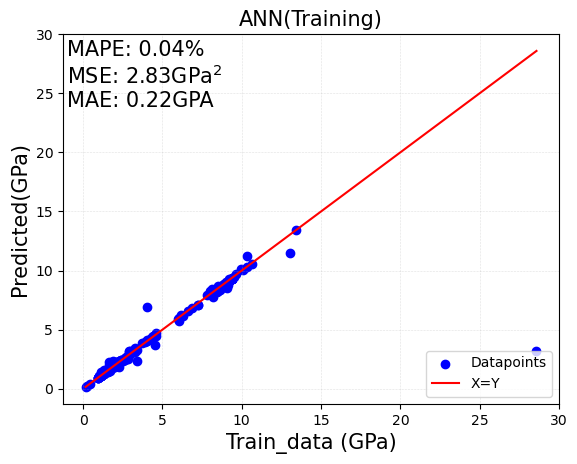

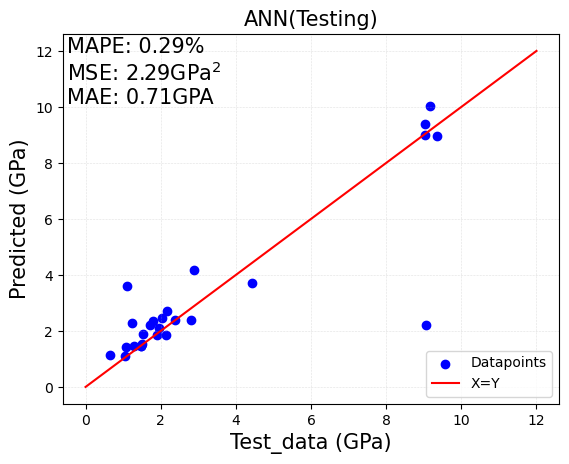

In [18]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(loss='mae',optimizer=optimizer, metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size= 32, validation_data=(X_test, y_test))
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test= mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color='b', label='Datapoints')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='r', label='X=Y')
plt.xlabel('Train_data (GPa)', fontsize=15)
plt.ylabel('Predicted(GPa)', fontsize = 15)
plt.text(-1,
        29.5,
        f"MAPE: {MAPE_train:.2f}%\nMSE: {MSE_train:.2f}GPa$^2$\nMAE: {MAE_train:.2f}GPA",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Training)', fontsize= 15)
#plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color='b', label='Datapoints')
plt.plot(x_plot, y_plot, color='r', label='X=Y')
plt.xlabel('Test_data (GPa)', fontsize = 15)
plt.ylabel('Predicted (GPa)', fontsize=15)
plt.text(-0.5,
        12.5,
        f"MAPE: {MAPE_test:.2f}%\nMSE: {MSE_test:.2f}GPa$^2$\nMAE: {MAE_test:.2f}GPA",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Testing)', fontsize=15)
#plt.legend()
plt.show()

Epoch 1/1000
8/8 [==============================] - 2s 35ms/step - loss: 3.6296 - mape: 90.9815 - val_loss: 2.5474 - val_mape: 63.7909
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.6428 - mape: 61.8718 - val_loss: 2.4003 - val_mape: 86.4363
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.5088 - mape: 86.6734 - val_loss: 2.1290 - val_mape: 66.6125
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.2604 - mape: 56.5026 - val_loss: 1.8914 - val_mape: 44.1033
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 2.1265 - mape: 50.4097 - val_loss: 1.9920 - val_mape: 60.8653
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.0623 - mape: 59.4466 - val_loss: 1.7729 - val_mape: 44.1777
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 1.9112 - mape: 42.2251 - val_loss: 1.7642 - val_mape: 48.6872
Epoch 8/1000
8/8 [==============================] - 0s 8ms/st

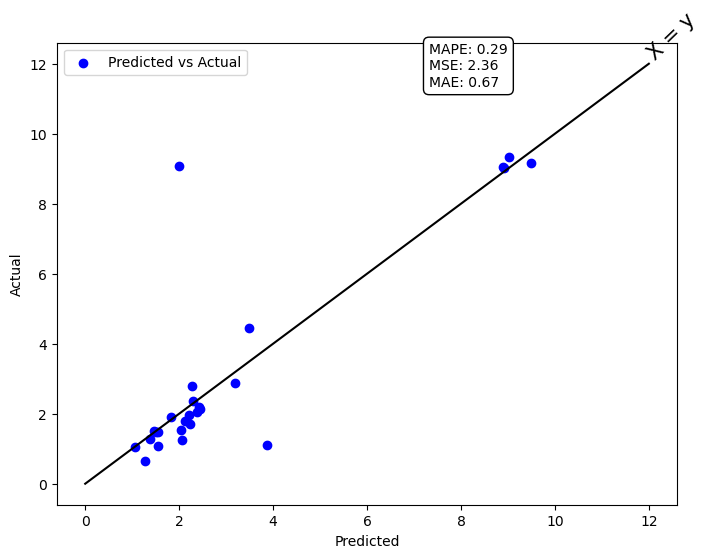

In [19]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(loss='mae',optimizer=optimizer, metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000,  batch_size= 32, validation_data=(X_test, y_test))
# Predict on the test set
predicted_values = model.predict(X_test)

# Calculate the error
mape = mean_absolute_percentage_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)

# Plotting
lw = 1

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    predicted_values,
    y_test,
    color='b',
    lw=lw,
    label="Predicted vs Actual"
)
ax.plot(
    x_plot,
    y_plot,
    color='black'
)

# Display the MAE as text annotation on the plot
ax.text(
    0.6,
    1,
    f"MAPE: {mape:.2f}\nMSE: {mse:.2f}\nMAE: {mae:.2f}",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
)
ax.text(
    11.9,
    12,
    "X = y",
    rotation=44,
    fontsize = 15,
    verticalalignment='bottom',
    )

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.legend()

plt.show()